Questo è il codice che include il lavoro fatto sulle basi del lab meeting tenuto in data 02 05 22


In [1]:
# carico i modelli dalla mia repository

def get_dbn_library():
  files = ["RBM.py", "Linear_model_tf.py"]
  repository_url = "https://raw.githubusercontent.com/LorenzoTausani/DBN/master/"
  for file in files:
    ! wget -O {file} {repository_url}{file}

get_dbn_library()

import RBM
import Linear_model_tf

--2022-05-07 22:47:27--  https://raw.githubusercontent.com/LorenzoTausani/DBN/master/RBM.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14650 (14K) [text/plain]
Saving to: ‘RBM.py’

RBM.py              100%[===================>]  14.31K  --.-KB/s    in 0s      

2022-05-07 22:47:27 (114 MB/s) - ‘RBM.py’ saved [14650/14650]

--2022-05-07 22:47:27--  https://raw.githubusercontent.com/LorenzoTausani/DBN/master/Linear_model_tf.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 272 [text/plain]
Saving to: ‘Linear_model_tf.py’

Line

In [2]:
# Importing the libraries
#from RBM_Padella2 import RBM
from Linear_model_tf import LinearClassifier

from RBM import RBM

import torch 
import torchvision
from torchvision import datasets,transforms
from torch.utils.data import Dataset,DataLoader

import matplotlib
import matplotlib.pyplot as plt

import math
import numpy as np
import os
import random

import time

In [5]:
'''
TO RETRIEVE TRAINED MODELS FROM GDRIVE

The cell will return the following and your needs to go 
to the link to retrieve the authorization code. Then you are good to go!
'''

from google.colab import drive
drive.mount('/content/gdrive')

MessageError: ignored

In [ ]:
def seed_everything(seed=42):
    """Seed everything to make the code more reproducable.

    This code is the same as that found from many public Kaggle kernels.

    Parameters
    ----------
    seed: int
        seed value to ues

    """
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [3]:
#device in use
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device {DEVICE}")

Using device cuda


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw

The number shown is the number: 2


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


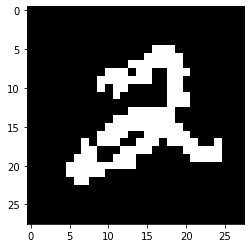

In [4]:
#importo dati mnist e binarizzo

#Loading MNIST dataset
mnist_data = datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose(
                    [transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))]))

mnist_data.data = (mnist_data.data.type(torch.FloatTensor)/255).bernoulli()
#https://stackoverflow.com/questions/68056122/attributeerror-cant-set-attribute-in-splitting-mnist-dataset

#Lets us visualize a number from the data set
idx = 5
img = mnist_data.train_data[idx]
print("The number shown is the number: {}".format(mnist_data.train_labels[idx]) )
plt.imshow(img , cmap = 'gray')
plt.show()

In [5]:
rbm_mnist = RBM(visible_units=28*28 ,
              hidden_units= 23*23 ,
              k = 5,
              learning_rate = 0.01,
              learning_rate_decay = True,
              xavier_init = True,
              increase_to_cd_k = False,
              use_gpu = False) #nota: use_gpu ora e useless

In [6]:
#dbn_mnist.train_static(mnist_data.data,mnist_data.train_labels,num_epochs , batch_size)
tmp = mnist_data.data
train_labels = mnist_data.train_labels

batch_size = 50
num_epochs = 20


tensor_x = tmp.type(torch.FloatTensor).to(DEVICE) # transform to torch tensors
tensor_y = train_labels.type(torch.FloatTensor).to(DEVICE)
_dataset = torch.utils.data.TensorDataset(tensor_x,tensor_y) # create your datset
_dataloader = torch.utils.data.DataLoader(_dataset,batch_size=batch_size,drop_last = True) # create your dataloader


start = time.time()

Avg_cost, Std_cost = rbm_mnist.train( _dataloader , num_epochs, batch_size)

end = time.time()

print(end - start)



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


RBM fitting: 1200it [00:04, 267.87it/s]
Epoch:1 ,avg_cost = 3.6026721000671387 ,std_cost = 0.6312618255615234 ,avg_grad = 7507.087890625 ,std_grad = 3113.6259765625
RBM fitting: 1200it [00:04, 270.36it/s]
Epoch:2 ,avg_cost = 2.9492435455322266 ,std_cost = 0.17596954107284546 ,avg_grad = 6180.9599609375 ,std_grad = 322.157470703125
RBM fitting: 1200it [00:04, 271.61it/s]
Epoch:3 ,avg_cost = 2.8071000576019287 ,std_cost = 0.1604233831167221 ,avg_grad = 5976.36669921875 ,std_grad = 300.0490417480469
RBM fitting: 1200it [00:04, 273.26it/s]
Epoch:4 ,avg_cost = 2.7427518367767334 ,std_cost = 0.15664377808570862 ,avg_grad = 5872.3984375 ,std_grad = 291.30816650390625
RBM fitting: 1200it [00:04, 267.06it/s]
Epoch:5 ,avg_cost = 2.695476531982422 ,std_cost = 0.1552431881427765 ,avg_grad = 5812.5341796875 ,std_grad = 288.1324157714844
RBM fitting: 1200it [00:05, 236.14it/s]
Epoch:6 ,avg_cost = 2.662508726119995 ,std_cost = 0.1537480503320694 ,avg_grad = 5772.37158203125 ,std_grad = 285.5507507324

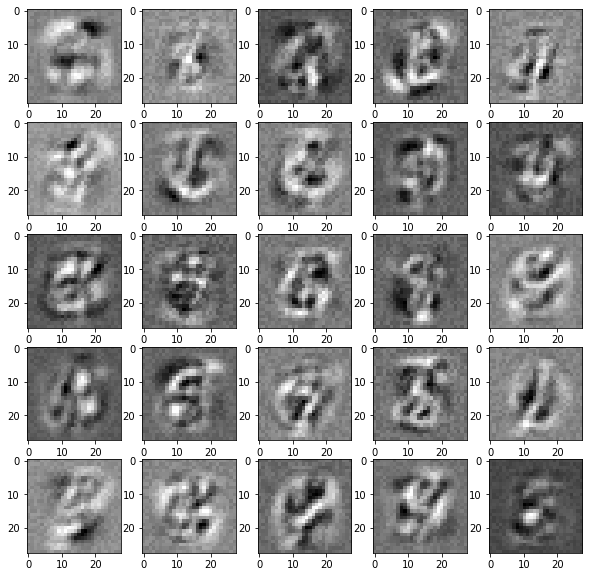

In [ ]:
# visualising layer 1
learned_weights = rbm_mnist.W.cpu().transpose(0,1).numpy()
plt.show()
fig = plt.figure(3, figsize=(10,10))
for i in range(25): 
    sub = fig.add_subplot(5, 5, i+1)
    sub.imshow(learned_weights[i,:].reshape((28,28)), cmap=plt.cm.gray)
plt.show()

<class 'torch.Tensor'>
The original number: 3


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


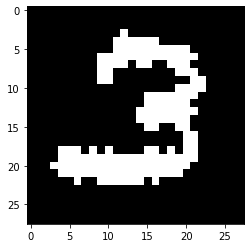

The reconstructed image


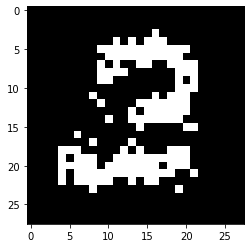

In [ ]:
#recostruction check

idx = random.randint(0,len(mnist_data.train_data))
img = mnist_data.train_data[idx]
lbl = mnist_data.train_labels[idx]
reconstructed_img = img.view(1,-1).type(torch.FloatTensor)

_,reconstructed_img= rbm_mnist.reconstruct(reconstructed_img,1)

print(type(lbl))

reconstructed_img = reconstructed_img.view((28,28)).cpu()
print("The original number: {}".format(lbl))
plt.imshow(img , cmap = 'gray')
plt.show()
print("The reconstructed image")
plt.imshow(reconstructed_img , cmap = 'gray')
plt.show()

In [7]:
rbm_mnist.create_h_tran_test_set(mnist_data.train_data, mnist_data.train_labels , nr_train_el=48000, nr_test_el=0, nr_gibbs=1)
#rbm_mnist.create_h_tran_test_set(mnist_data.train_data, mnist_data.train_labels , nr_train_el=0, nr_test_el=12000, nr_gibbs=10)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [36]:
nr_e = 100
rbm_mnist.train_h_Linear_classifier(nr_epochs=nr_e, Lr=0.01)

Epoch: 0, loss: 0.3084853604435921
Epoch: 1, loss: 0.3084298220851148
Epoch: 2, loss: 0.30833050739020107
Epoch: 3, loss: 0.3083188551012427
Epoch: 4, loss: 0.30819135256266844
Epoch: 5, loss: 0.30800938690857343
Epoch: 6, loss: 0.3079095968588566
Epoch: 7, loss: 0.3078553418861702
Epoch: 8, loss: 0.30778758286808927
Epoch: 9, loss: 0.30757049346963566
Epoch: 10, loss: 0.30763803272663304
Epoch: 11, loss: 0.3075257353562241
Epoch: 12, loss: 0.3074803400901146
Epoch: 13, loss: 0.3073770531375582
Epoch: 14, loss: 0.30729273811060315
Epoch: 15, loss: 0.30719525370902073
Epoch: 16, loss: 0.3069950366315121
Epoch: 17, loss: 0.3071455352163563
Epoch: 18, loss: 0.3069482416380197
Epoch: 19, loss: 0.3067636928365876
Epoch: 20, loss: 0.306797950854525
Epoch: 21, loss: 0.3067779696856936
Epoch: 22, loss: 0.3065840803125563
Epoch: 23, loss: 0.3065826618578285
Epoch: 24, loss: 0.30664247697762526
Epoch: 25, loss: 0.3064453323449319
Epoch: 26, loss: 0.3063262212012584
Epoch: 27, loss: 0.30632993798

[0.3084853604435921,
 0.3084298220851148,
 0.30833050739020107,
 0.3083188551012427,
 0.30819135256266844,
 0.30800938690857343,
 0.3079095968588566,
 0.3078553418861702,
 0.30778758286808927,
 0.30757049346963566,
 0.30763803272663304,
 0.3075257353562241,
 0.3074803400901146,
 0.3073770531375582,
 0.30729273811060315,
 0.30719525370902073,
 0.3069950366315121,
 0.3071455352163563,
 0.3069482416380197,
 0.3067636928365876,
 0.306797950854525,
 0.3067779696856936,
 0.3065840803125563,
 0.3065826618578285,
 0.30664247697762526,
 0.3064453323449319,
 0.3063262212012584,
 0.30632993798159686,
 0.30623442065746836,
 0.3063420543524747,
 0.3061250966275111,
 0.3060669029286752,
 0.30599427958174297,
 0.3059536199706296,
 0.3058340984086196,
 0.3059248253159846,
 0.3056319243235824,
 0.30588406113286815,
 0.3056714183767326,
 0.3056468531411762,
 0.30561992498114704,
 0.30558268757692225,
 0.30549005277377245,
 0.30542957682628186,
 0.3053172201112223,
 0.3053047325772544,
 0.305299705577393

In [ ]:
start = time.time()

perf_list=[]

for i in range(1, 1, 20):
  rbm_mnist.create_h_tran_test_set(mnist_data.train_data, mnist_data.train_labels , nr_train_el=0, nr_test_el=12000, nr_gibbs=i)
  perf_list.append(rbm_mnist.test_h_Linear_classifier())
  rbm_mnist.reset_h_tran_test_set(test=True)


end = time.time()

print(end - start)

0.0003437995910644531


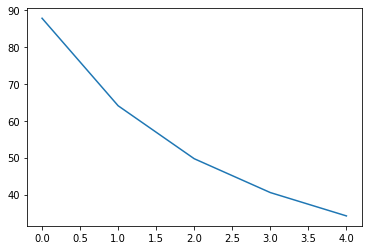

In [ ]:
plt.plot(perf_list)

In [9]:
#rbm_mnist.reset_h_tran_test_set(test=True)

rbm_mnist.create_h_tran_test_set(mnist_data.train_data, mnist_data.train_labels , nr_train_el=0, nr_test_el=12000, nr_gibbs=1)

rbm_mnist.h_test_dataset.shape

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


torch.Size([12000, 529])

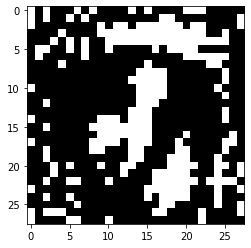

In [40]:
h = rbm_mnist.h_from_label(1,80)

v, sample_v = rbm_mnist.to_visible(h)

reconstructed_img = sample_v.view((28,28)).cpu()

plt.imshow(reconstructed_img , cmap = 'gray')

In [ ]:
File_name= 'RBM_mnist_h'+str(rbm_mnist.hidden_units)+'_TrainEpochs'+str(nr_e)+'.pth'
path = F"/content/gdrive/My Drive/{File_name}"
torch.save(rbm_mnist.state_dict(), path)

In [ ]:
model_save_name = 'classifier.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(model.state_dict(), path)